### Basic Transformer Encoder from Scratch Using PyTorch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleTransformerEncoder(nn.Module):
    def __init__(self, embed_size, ff_hidden_size, num_layers, dropout=0.1):
        super(SimpleTransformerEncoder, self).__init__()

        # Embedding dimension and the number of layers
        self.embed_size = embed_size
        self.num_layers = num_layers

        # Positional Encoding layer
        self.positional_encoding = nn.Parameter(torch.zeros(1, 5000, embed_size))  # Assume max sequence length is 5000

        # Feed Forward Network
        self.ffn = nn.Sequential(
            nn.Linear(embed_size, ff_hidden_size),
            nn.ReLU(),
            nn.Linear(ff_hidden_size, embed_size)
        )

        # Layer Normalization
        self.layer_norm = nn.LayerNorm(embed_size)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Add positional encoding
        x = x + self.positional_encoding[:, :x.size(1), :]

        for _ in range(self.num_layers):
            # Apply feed-forward network (no attention, just FFN here)
            out = self.ffn(x)

            # Apply layer normalization
            out = self.layer_norm(out)

            # Apply dropout
            out = self.dropout(out)

            # Add residual connection
            x = x + out

        return x

# Example usage
batch_size = 2
seq_len = 10
embed_size = 256
ff_hidden_size = 512
num_layers = 4

# Sample input (random tensors)
x = torch.rand(batch_size, seq_len, embed_size)

# Instantiate the model
encoder = SimpleTransformerEncoder(embed_size=embed_size, ff_hidden_size=ff_hidden_size, num_layers=num_layers)

# Forward pass
output = encoder(x)
print(output.shape)  # Expected output shape: (batch_size, seq_len, embed_size)


torch.Size([2, 10, 256])


### Implementing Self-Attention from Scratch in Python

In [ ]:
import numpy as np

class SelfAttention:
    def __init__(self, embed_size):
        self.embed_size = embed_size
        self.scaling_factor = np.sqrt(embed_size)  # for scaling the dot product

    def forward(self, Q, K, V):
        """
        Compute the self-attention scores and apply them to the Value matrix (V).

        Args:
            Q (np.ndarray): Query matrix of shape (batch_size, seq_len, embed_size)
            K (np.ndarray): Key matrix of shape (batch_size, seq_len, embed_size)
            V (np.ndarray): Value matrix of shape (batch_size, seq_len, embed_size)

        Returns:
            np.ndarray: Output matrix after applying attention (batch_size, seq_len, embed_size)
        """
        # Step 1: Compute the dot product of Q and K (transpose K)
        attention_scores = np.matmul(Q, K.transpose(0, 2, 1))  # (batch_size, seq_len, seq_len)

        # Step 2: Scale the scores by sqrt(d_k)
        attention_scores = attention_scores / self.scaling_factor

        # Step 3: Apply softmax to get attention weights
        attention_weights = self.softmax(attention_scores)  # (batch_size, seq_len, seq_len)

        # Step 4: Multiply the attention weights by V to get the output
        output = np.matmul(attention_weights, V)  # (batch_size, seq_len, embed_size)

        return output

    def softmax(self, scores):
        """
        Apply softmax on the last axis (seq_len dimension) for each batch.
        """
        exp_scores = np.exp(scores - np.max(scores, axis=-1, keepdims=True))  # for numerical stability
        return exp_scores / np.sum(exp_scores, axis=-1, keepdims=True)

# Example usage
batch_size = 2
seq_len = 5
embed_size = 4

# Random matrices for Q, K, and V (batch_size, seq_len, embed_size)
Q = np.random.rand(batch_size, seq_len, embed_size)
K = np.random.rand(batch_size, seq_len, embed_size)
V = np.random.rand(batch_size, seq_len, embed_size)

# Instantiate self-attention layer
self_attention = SelfAttention(embed_size)

# Forward pass
output = self_attention.forward(Q, K, V)
print("Attention Output Shape:", output.shape)


Attention Output Shape: (2, 5, 4)


### Creating a Multi-Head Attention Layer Using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        # Ensure embed_size is divisible by the number of heads
        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by number of heads"

        # Linear layers for Q, K, V projections
        self.query = nn.Linear(embed_size, embed_size)
        self.key = nn.Linear(embed_size, embed_size)
        self.value = nn.Linear(embed_size, embed_size)

        # Final output linear layer
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask=None):
        # Number of batches (assume same batch size for all inputs)
        batch_size = query.shape[0]

        # Linear projections of queries, keys, values
        Q = self.query(query)
        K = self.key(keys)
        V = self.value(values)

        # Reshape Q, K, V for multi-head attention (batch_size, heads, seq_len, head_dim)
        Q = Q.reshape(batch_size, -1, self.heads, self.head_dim).transpose(1, 2)  # (batch_size, heads, seq_len, head_dim)
        K = K.reshape(batch_size, -1, self.heads, self.head_dim).transpose(1, 2)  # (batch_size, heads, seq_len, head_dim)
        V = V.reshape(batch_size, -1, self.heads, self.head_dim).transpose(1, 2)  # (batch_size, heads, seq_len, head_dim)

        # Scaled dot-product attention
        energy = torch.matmul(Q, K.transpose(-2, -1))  # (batch_size, heads, query_len, key_len)

        # Scale by sqrt(head_dim) to prevent gradient explosion
        energy = energy / (self.head_dim ** (1 / 2))

        # Apply mask (optional)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-inf'))

        # Attention scores (weights)
        attention = torch.softmax(energy, dim=-1)  # (batch_size, heads, query_len, key_len)

        # Weighted sum of values
        out = torch.matmul(attention, V)  # (batch_size, heads, query_len, head_dim)

        # Reshape output to (batch_size, query_len, embed_size)
        out = out.transpose(1, 2).reshape(batch_size, -1, self.heads * self.head_dim)

        # Final linear layer
        out = self.fc_out(out)

        return out

# Example usage:
batch_size = 2
seq_len = 10
embed_size = 256  # Should be divisible by number of heads
heads = 8

# Sample input (random tensors)
values = torch.rand(batch_size, seq_len, embed_size)
keys = torch.rand(batch_size, seq_len, embed_size)
query = torch.rand(batch_size, seq_len, embed_size)

# Instantiate the MultiHeadAttention layer
mha = MultiHeadAttention(embed_size=embed_size, heads=heads)

# Forward pass
output = mha(values, keys, query)
print(output.shape)  # Expected output shape: (batch_size, seq_len, embed_size)


torch.Size([2, 10, 256])


torch.Size([2, 10, 256])

### Implementing and Visualizing Positional Encodings in Python

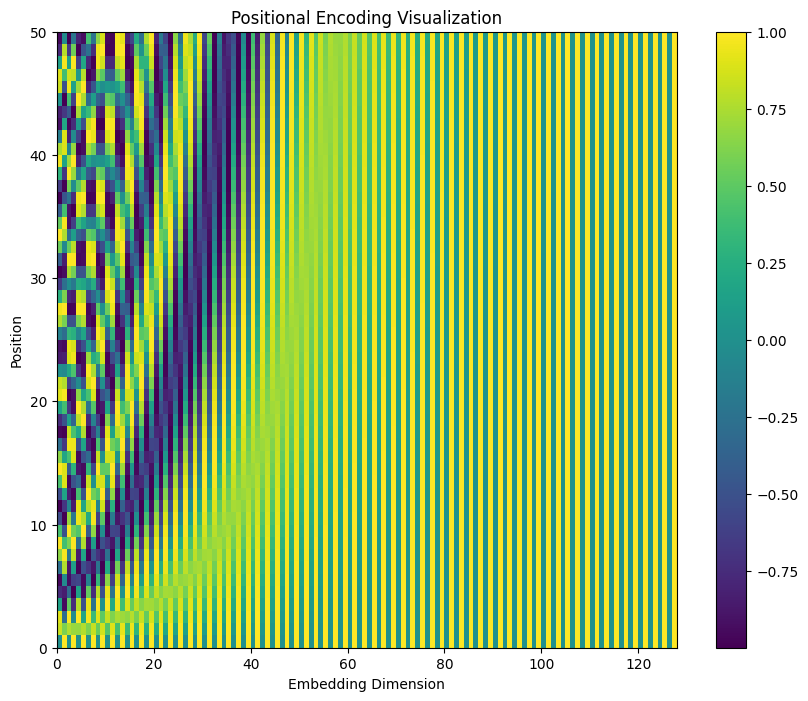

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class PositionalEncoding:
    def __init__(self, seq_len, embed_size):
        """
        Initializes the positional encoding.
        Args:
            seq_len (int): Length of the input sequence (number of tokens).
            embed_size (int): The embedding dimension (size of the token vectors).
        """
        self.seq_len = seq_len
        self.embed_size = embed_size

    def forward(self):
        """
        Generates positional encodings for the sequence.
        Returns:
            np.ndarray: A matrix of shape (seq_len, embed_size) representing the positional encodings.
        """
        # Create an empty matrix to store the positional encodings
        pos_encodings = np.zeros((self.seq_len, self.embed_size))

        # Apply the sine and cosine functions as defined in the formula
        for pos in range(self.seq_len):
            for i in range(0, self.embed_size, 2):
                pos_encodings[pos, i] = np.sin(pos / (10000 ** (i / self.embed_size)))
                if i + 1 < self.embed_size:
                    pos_encodings[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / self.embed_size)))

        return pos_encodings

    def visualize(self):
        """
        Visualizes the positional encodings for the first few positions and dimensions.
        """
        # Generate positional encodings
        pos_encodings = self.forward()

        # Plot the positional encodings
        plt.figure(figsize=(10, 8))
        plt.pcolormesh(pos_encodings, cmap='viridis', shading='auto')
        plt.xlabel('Embedding Dimension')
        plt.ylabel('Position')
        plt.colorbar()
        plt.title('Positional Encoding Visualization')
        plt.show()

# Example usage
seq_len = 50  # Length of the sequence (number of tokens)
embed_size = 128  # Embedding dimension (size of the token vectors)

# Initialize positional encoding
pos_encoder = PositionalEncoding(seq_len, embed_size)

# Visualize the positional encodings
pos_encoder.visualize()


### Building a Full Transformer Block Using PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.embed_size = embed_size
        self.positional_encoding = self._generate_positional_encoding(max_len, embed_size)

    def _generate_positional_encoding(self, max_len, embed_size):
        pos_encodings = np.zeros((max_len, embed_size))
        for pos in range(max_len):
            for i in range(0, embed_size, 2):
                pos_encodings[pos, i] = np.sin(pos / (10000 ** (i / embed_size)))
                if i + 1 < embed_size:
                    pos_encodings[pos, i + 1] = np.cos(pos / (10000 ** ((i + 1) / embed_size)))
        return torch.tensor(pos_encodings, dtype=torch.float32)

    def forward(self, x):
        seq_len = x.size(1)
        return x + self.positional_encoding[:seq_len, :]

# --- Scaled Dot-Product Attention ---
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by the number of heads"

        self.values = nn.Linear(embed_size, embed_size)
        self.keys = nn.Linear(embed_size, embed_size)
        self.queries = nn.Linear(embed_size, embed_size)
        self.fc_out = nn.Linear(embed_size, embed_size)

    def forward(self, values, keys, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim).transpose(1, 2)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim).transpose(1, 2)
        query = query.reshape(N, query_len, self.heads, self.head_dim).transpose(1, 2)

        energy = torch.matmul(query, keys.transpose(2, 3))  # Scaled dot-product attention
        energy = energy / (self.head_dim ** (1 / 2))  # Scaling factor

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float('-1e20'))

        attention = torch.softmax(energy, dim=-1)  # Apply softmax to get attention weights
        out = torch.matmul(attention, values)  # Multiply by values

        out = out.transpose(1, 2).reshape(N, query_len, self.heads * self.head_dim)
        out = self.fc_out(out)
        return out

# --- Feedforward Neural Network ---
class FeedForward(nn.Module):
    def __init__(self, embed_size, ff_hidden_size, dropout=0.1):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(embed_size, ff_hidden_size)
        self.fc2 = nn.Linear(ff_hidden_size, embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# --- Encoder Block ---
class EncoderBlock(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size, dropout=0.1):
        super(EncoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.ffn = FeedForward(embed_size, ff_hidden_size, dropout)
        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask):
        attention = self.attention(value, key, query, mask)
        x = self.layer_norm1(attention + query)  # Residual connection
        ff_out = self.ffn(x)
        out = self.layer_norm2(ff_out + x)  # Residual connection
        return out

# --- Decoder Block ---
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, ff_hidden_size, dropout=0.1):
        super(DecoderBlock, self).__init__()
        self.attention = SelfAttention(embed_size, heads)
        self.encoder_attention = SelfAttention(embed_size, heads)
        self.ffn = FeedForward(embed_size, ff_hidden_size, dropout)
        self.layer_norm1 = nn.LayerNorm(embed_size)
        self.layer_norm2 = nn.LayerNorm(embed_size)
        self.layer_norm3 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, value, key, query, mask, encoder_output):
        attention = self.attention(query, query, query, mask)
        x = self.layer_norm1(attention + query)  # Residual connection
        encoder_attention = self.encoder_attention(value, key, x, mask)
        x = self.layer_norm2(encoder_attention + x)  # Residual connection
        ff_out = self.ffn(x)
        out = self.layer_norm3(ff_out + x)  # Residual connection
        return out

# --- Transformer Model ---
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, embed_size, heads, ff_hidden_size, num_encoder_layers, num_decoder_layers, dropout=0.1):
        super(Transformer, self).__init__()
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.embed_size = embed_size
        self.num_encoder_layers = num_encoder_layers
        self.num_decoder_layers = num_decoder_layers

        self.src_embedding = nn.Embedding(src_vocab_size, embed_size)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        self.encoder_blocks = nn.ModuleList([EncoderBlock(embed_size, heads, ff_hidden_size, dropout) for _ in range(num_encoder_layers)])
        self.decoder_blocks = nn.ModuleList([DecoderBlock(embed_size, heads, ff_hidden_size, dropout) for _ in range(num_decoder_layers)])

        self.fc_out = nn.Linear(embed_size, tgt_vocab_size)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        src_emb = self.positional_encoding(self.src_embedding(src))
        tgt_emb = self.positional_encoding(self.tgt_embedding(tgt))

        # Pass through encoder
        encoder_output = src_emb
        for encoder in self.encoder_blocks:
            encoder_output = encoder(encoder_output, encoder_output, encoder_output, src_mask)

        # Pass through decoder
        decoder_output = tgt_emb
        for decoder in self.decoder_blocks:
            decoder_output = decoder(encoder_output, encoder_output, decoder_output, tgt_mask, encoder_output)

        output = self.fc_out(decoder_output)
        return output

# Example Usage
src_vocab_size = 1000
tgt_vocab_size = 1000
embed_size = 256
heads = 8
ff_hidden_size = 512
num_encoder_layers = 6
num_decoder_layers = 6
batch_size = 32
seq_len = 20

# Instantiate transformer model
transformer = Transformer(src_vocab_size, tgt_vocab_size, embed_size, heads, ff_hidden_size, num_encoder_layers, num_decoder_layers)

# Example input (source and target sequences)
src = torch.randint(0, src_vocab_size, (batch_size, seq_len))
tgt = torch.randint(0, tgt_vocab_size, (batch_size, seq_len))

# Forward pass
output = transformer(src, tgt)
print(output.shape)  # Expected shape: (batch_size, seq_len, tgt_vocab_size)


torch.Size([32, 20, 1000])


### Sentiment Classification Using DistilBert

In [ ]:
# Install the necessary libraries if you haven't already
# !pip install transformers
# !pip install torch

import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline

# Load pre-trained DistilBERT model and tokenizer for sentiment analysis
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# Define a function to classify sentiment
def classify_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    predicted_class = torch.argmax(outputs.logits).item()
    sentiment = "Positive" if predicted_class == 1 else "Negative"
    return sentiment

# Example text for sentiment classification
text_to_classify = "I loved the movie, it was fantastic!"

# Classify sentiment using the DistilBERT model
predicted_sentiment = classify_sentiment(text_to_classify)

# Print the predicted sentiment
print("Predicted Sentiment:", predicted_sentiment)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Predicted Sentiment: Positive


### Fine-Tuning a Pretrained BERT Model for Sentiment Analysis


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import numpy as np
from scipy.special import softmax
import pandas as pd

# Define the pretrained model to use
MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Dataset example
class SentimentDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_tensors="pt",
            truncation=True,
            padding="max_length"
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'text': text
        }

# Define sample texts
texts = [
    "I absolutely loved this product!",
    "The service was terrible and I hated the food.",
    "It was fine, not amazing but not bad either.",
    "Excellent experience, would come again!",
    "This was a waste of money and time.",
]

# Create dataset and dataloader
dataset = SentimentDataset(texts, tokenizer)
dataloader = DataLoader(dataset, batch_size=2)

# Function to predict sentiment
def predict_sentiment(model, dataloader, device):
    model.eval()
    results = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            probs = softmax(outputs.logits.cpu().numpy(), axis=1)  # Convert logits to probabilities
            predictions = np.argmax(probs, axis=1)  # Get predicted classes
            for i, text in enumerate(batch['text']):
                results.append({
                    'text': text,
                    'predicted_class': predictions[i],
                    'confidence': probs[i][predictions[i]]
                })
    return results

# Predict and display results
predictions = predict_sentiment(model, dataloader, device)

# Map classes to sentiment labels (specific to this model)
sentiment_labels = {
    0: "Very Negative",
    1: "Negative",
    2: "Neutral",
    3: "Positive",
    4: "Very Positive"
}

print("Sentiment Analysis Results:")
for result in predictions:
    print(f"Text: {result['text']}")
    print(f"Predicted Sentiment: {sentiment_labels[result['predicted_class']]} (Confidence: {result['confidence']:.2f})\n")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

Sentiment Analysis Results:
Text: I absolutely loved this product!
Predicted Sentiment: Very Positive (Confidence: 0.95)

Text: The service was terrible and I hated the food.
Predicted Sentiment: Very Negative (Confidence: 0.78)

Text: It was fine, not amazing but not bad either.
Predicted Sentiment: Neutral (Confidence: 0.59)

Text: Excellent experience, would come again!
Predicted Sentiment: Very Positive (Confidence: 0.86)

Text: This was a waste of money and time.
Predicted Sentiment: Very Negative (Confidence: 0.83)



### Transformers Text Summarization

In [ ]:
# Install the necessary libraries if you haven't already
# !pip install transformers torch

from transformers import BartForConditionalGeneration, BartTokenizer

# Load pre-trained BART model and tokenizer for summarization
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")

# Define a function to summarize text
def summarize_text(text):
    inputs = tokenizer(text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=40, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

# Example text for summarization
text_to_summarize = (
    "The BART model is a state-of-the-art model for text generation tasks, including summarization. "
    "It combines the capabilities of BERT and GPT, allowing it to understand context while generating coherent text. "
    "BART has been shown to produce high-quality summaries that maintain the essence of the original content."
)

# Summarize the text using the BART model
summary = summarize_text(text_to_summarize)

# Print the generated summary
print("Generated Summary:", summary)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Generated Summary: The BART model is a state-of-the-art model for text generation tasks, including summarization. BART has been shown to produce high-quality summaries that maintain the essence of the original content.


### Sentiment Classification Using Transformers

In [ ]:
from transformers import pipeline

# Load a pre-trained sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Function to predict sentiment
def predict_sentiment(user_input):
    result = sentiment_analyzer(user_input)
    sentiment = result[0]['label']
    score = result[0]['score']
    return sentiment, score

# Get input from the user
user_text = input("Enter a sentence to analyze sentiment: ")

# Predict sentiment
sentiment, confidence = predict_sentiment(user_text)

# Output the results
print(f"Sentiment: {sentiment}\nConfidence: {confidence:.2f}")


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


Enter a sentence to analyze sentiment: I love Dogs
Sentiment: POSITIVE
Confidence: 1.00


### Sentence Transformers for semantic similarity search

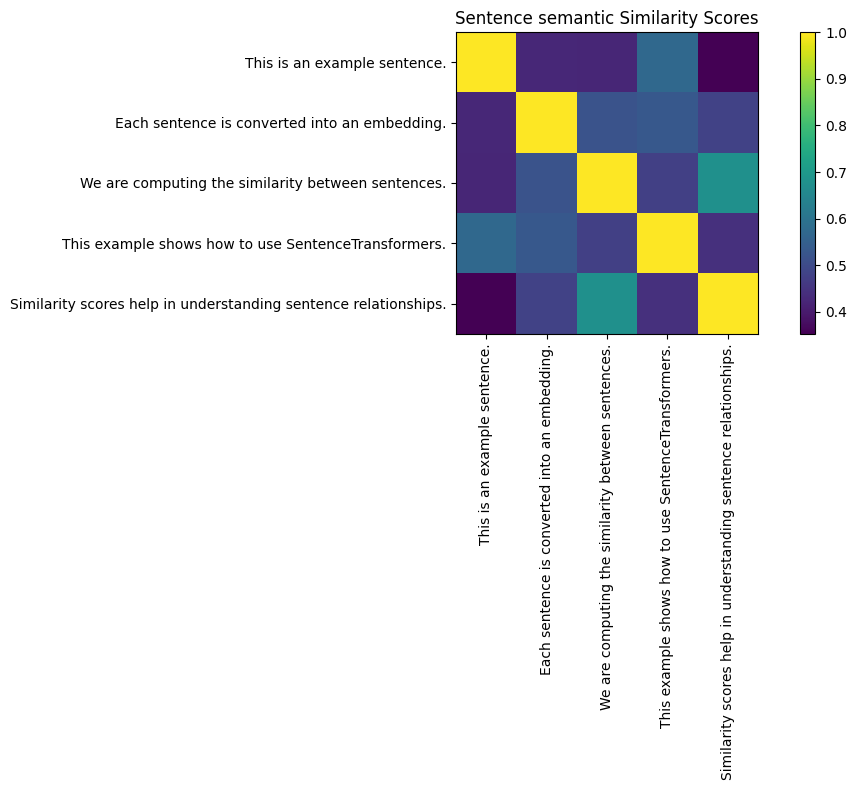

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np

def get_sentence_embeddings(sentences):
    """
    Encode the given sentences into embeddings using a pretrained SentenceTransformer model.

    Parameters:
    - sentences (list of str): List of sentences to encode.

    Returns:
    - np.ndarray: Encoded sentence embeddings.
    """
    model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v1')
    embeddings = model.encode(sentences)
    return embeddings

def calculate_similarity(embeddings):
    """
    Calculate the cosine similarity score between sentence embeddings.

    Parameters:
    - embeddings (np.ndarray): Array of sentence embeddings.

    Returns:
    - np.ndarray: Cosine similarity matrix.
    """
    return cosine_similarity(embeddings)

def plot_similarity_matrix(similarity_matrix, sentences):
    """
    Plot a heatmap to visualize the similarity scores between sentences.

    Parameters:
    - similarity_matrix (np.ndarray): Cosine similarity matrix.
    - sentences (list of str): List of sentences corresponding to the similarity matrix.
    """
    plt.figure(figsize=(12, 8))
    plt.imshow(similarity_matrix, interpolation='nearest', cmap='viridis')
    plt.colorbar()
    plt.xticks(range(len(sentences)), sentences, rotation=90)
    plt.yticks(range(len(sentences)), sentences)
    plt.title('Sentence semantic Similarity Scores')
    plt.tight_layout()
    plt.show()

def main():
    # Sample sentences
    sentences = [
        "This is an example sentence.",
        "Each sentence is converted into an embedding.",
        "We are computing the similarity between sentences.",
        "This example shows how to use SentenceTransformers.",
        "Similarity scores help in understanding sentence relationships."
    ]

    # Get sentence embeddings
    embeddings = get_sentence_embeddings(sentences)

    # Calculate similarity matrix
    similarity_matrix = calculate_similarity(embeddings)

    # Plot the similarity matrix
    plot_similarity_matrix(similarity_matrix, sentences)

if __name__ == "__main__":
    main()


### Transformers Machine Translation

In [ ]:
import numpy as np
from transformers import MarianTokenizer, MarianMTModel

# Define the model and tokenizer for machine translation
model_name = "Helsinki-NLP/opus-mt-en-de"  # English to German model
model = MarianMTModel.from_pretrained(model_name)
tokenizer = MarianTokenizer.from_pretrained(model_name)

# Function for translation
def translate_text(text, tokenizer, model):
    # Tokenize the input text
    tokenized_text = tokenizer.prepare_seq2seq_batch([text], return_tensors="pt")

    # Perform the translation
    translated_tokens = model.generate(**tokenized_text)

    # Decode the tokens into human-readable text
    translated_text = tokenizer.decode(translated_tokens[0], skip_special_tokens=True)
    return translated_text

# Test the translation function
texts_to_translate = [
    "Hello, how are you?",
    "The weather is nice today.",
    "I would like a cup of coffee, please."
]

for text in texts_to_translate:
    translated = translate_text(text, tokenizer, model)
    print(f"Original: {text}\nTranslated: {translated}\n")

config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4079: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `pr

Original: Hello, how are you?
Translated: Hallo, wie geht's?

Original: The weather is nice today.
Translated: Das Wetter ist heute schön.

Original: I would like a cup of coffee, please.
Translated: Ich hätte gern eine Tasse Kaffee, bitte.



### Implementing a Question-Answering System Using Hugging Face Transformers

In [ ]:
from transformers import pipeline

# Step 1: Load a specific pre-trained model and tokenizer for question answering
qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad", tokenizer="distilbert-base-uncased")

# Step 2: Define context and question
context = """
The Eiffel Tower is a wrought-iron lattice tower on the Champ de Mars in Paris, France.
It is named after the engineer Gustave Eiffel, whose company designed and built the tower.
The tower was completed in 1889 as the entrance arch to the 1889 World's Fair.
"""

question = "Who designed the Eiffel Tower?"

# Step 3: Ask the question to the model
result = qa_pipeline(question=question, context=context)

# Step 4: Print the result
print(f"question: {question}")
print(f"Answer: {result['answer']}")


Device set to use cpu


question: Who designed the Eiffel Tower?
Answer: Gustave Eiffel


### Custom finetuned Transformers for Machine Translation


In [ ]:
import numpy as np
import pandas as pd
from transformers import MarianTokenizer, MarianMTModel
import torch

# Define available translation models
translation_models = {
    "en-de": "Helsinki-NLP/opus-mt-en-de",  # English to German
    "en-fr": "Helsinki-NLP/opus-mt-en-fr",  # English to French
    "en-es": "Helsinki-NLP/opus-mt-en-es",  # English to Spanish
    "en-zh": "Helsinki-NLP/opus-mt-en-zh",  # English to Chinese
}

# Function to load model and tokenizer dynamically
def load_translation_model(language_pair):
    if language_pair not in translation_models:
        raise ValueError(f"Language pair {language_pair} not supported.")
    model_name = translation_models[language_pair]
    model = MarianMTModel.from_pretrained(model_name)
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    return model, tokenizer

# Function for batch translation
def translate_texts(texts, tokenizer, model, batch_size=4):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        try:
            # Tokenize the input text batch
            tokenized_batch = tokenizer.prepare_seq2seq_batch(batch_texts, return_tensors="pt", padding=True)
            tokenized_batch = {k: v.to(torch.device("cuda" if torch.cuda.is_available() else "cpu")) for k, v in tokenized_batch.items()}

            # Perform the translation
            translated_tokens = model.generate(**tokenized_batch)

            # Decode the tokens into human-readable text
            translated_texts = [tokenizer.decode(t, skip_special_tokens=True) for t in translated_tokens]
            results.extend(translated_texts)
        except Exception as e:
            results.extend([f"Error: {str(e)}"] * len(batch_texts))
    return results

# Input texts to translate
texts_to_translate = [
    "Hello, how are you?",
    "The weather is nice today.",
    "I would like a cup of coffee, please.",
    "Machine translation has improved significantly in recent years.",
    "This is a test of a multilingual translation system.",
]

# Language pairs to translate
language_pairs = ["en-de", "en-fr", "en-es"]

# Perform translations for each language pair
all_translations = []
for language_pair in language_pairs:
    print(f"\nTranslating to: {language_pair.split('-')[1].capitalize()}")
    model, tokenizer = load_translation_model(language_pair)
    translations = translate_texts(texts_to_translate, tokenizer, model)
    for original, translated in zip(texts_to_translate, translations):
        print(f"Original: {original}\nTranslated: {translated}\n")
        all_translations.append({"Original": original, "Translated": translated, "Language": language_pair.split('-')[1]})

# Save results to a CSV file
df_translations = pd.DataFrame(all_translations)
output_file = "translations_results.csv"
df_translations.to_csv(output_file, index=False)
print(f"\nTranslations saved to {output_file}.")



Translating to: De


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/298M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/768k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/797k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4079: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and targets.

Here is a short example:

model_inputs = tokenizer(src_texts, text_target=tgt_texts, ...)

If you either need to use different keyword arguments for the source and target texts, you should do two calls like
this:

model_inputs = tokenizer(src_texts, ...)
labels = tokenizer(text_target=tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `pr

Original: Hello, how are you?
Translated: Hallo, wie geht's?

Original: The weather is nice today.
Translated: Das Wetter ist heute schön.

Original: I would like a cup of coffee, please.
Translated: Ich hätte gern eine Tasse Kaffee, bitte.

Original: Machine translation has improved significantly in recent years.
Translated: Maschinelle Übersetzung hat sich in den letzten Jahren deutlich verbessert.

Original: This is a test of a multilingual translation system.
Translated: Dies ist ein Test für ein mehrsprachiges Übersetzungssystem.


Translating to: Fr


config.json:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/301M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/778k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Original: Hello, how are you?
Translated: Bonjour, comment allez-vous ?

Original: The weather is nice today.
Translated: Le temps est beau aujourd'hui.

Original: I would like a cup of coffee, please.
Translated: Je voudrais une tasse de café, s'il vous plaît.

Original: Machine translation has improved significantly in recent years.
Translated: La traduction automatique s'est considérablement améliorée ces dernières années.

Original: This is a test of a multilingual translation system.
Translated: Il s'agit d'un test d'un système de traduction multilingue.


Translating to: Es


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Original: Hello, how are you?
Translated: Hola, ¿cómo estás?

Original: The weather is nice today.
Translated: Hoy hace buen tiempo.

Original: I would like a cup of coffee, please.
Translated: Me gustaría una taza de café, por favor.

Original: Machine translation has improved significantly in recent years.
Translated: La traducción automática ha mejorado significativamente en los últimos años.

Original: This is a test of a multilingual translation system.
Translated: Esta es una prueba de un sistema de traducción multilingüe.


Translations saved to translations_results.csv.


In [ ]:
import pandas as pd

df = pd.read_csv('/content/translations_results.csv')
df.head()

,Original,Translated,Language
0,"Hello, how are you?","Hallo, wie geht's?",de
1,The weather is nice today.,Das Wetter ist heute schön.,de
2,"I would like a cup of coffee, please.","Ich hätte gern eine Tasse Kaffee, bitte.",de
3,Machine translation has improved significantly...,Maschinelle Übersetzung hat sich in den letzte...,de
4,This is a test of a multilingual translation s...,Dies ist ein Test für ein mehrsprachiges Übers...,de
